# Exploring the CIC-IDS-2018 Dataset (processed_wednesday1_dataset)

Malicious: 19.09%, Benign: 80.91%.

In [1]:
# Import modules
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from minisom import MiniSom
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve

In [2]:
# Import dataset
df_dataset = pd.read_csv("/users/mik2002/aws-dataset/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv")
pd.set_option('display.max_columns', None)
display(df_dataset.head(10))

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026633,5.632086e+07,139.300036,56320958,56320761,112641719,5.632086e+07,139.300036,56320958,56320761,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026633,5.632073e+07,114.551299,56320814,56320652,112641466,5.632073e+07,114.551299,56320814,56320652,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026634,5.631931e+07,301.934596,56319525,56319098,112638623,5.631931e+07,301.934596,56319525,56319098,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0.026634,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,82.600000,196.741237,976,0,227.300000,371.677892,544.161528,3.873587,2.689152e+05,247443.778966,673900,22,6453966,4.609976e+05,123109.423588,673900,229740,5637902,626433.555556,455082.214224,1167293,554,0,0,0,0,488,328,2.324152,1.549435,0,976,135.076923,277.834760,77192.153846,0,0,0,1,0,0,0,0,0,140.480000,82.600000,227.300000,0,0,0,0,0,0,15,1239,10,2273,65535,233,6,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,81.642857,203.745545,976,0,200.818182,362.249864,380.733175,2.839597,3.668361e+05,511356.609733,1928102,21,8804066,6.772358e+05,532416.970959,1928102,246924,7715481,771548.100000,755543.082717,2174893,90,0,0,0,0,456,360,1.590174,1.249423,0,976,128.923077,279.763032,78267.353846,0,0,0,1,0,0,0,0,0,134.080000,81.642857,200.818182,0,0,0,0,0,0,14,1143,11,2209,5808,233,6,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
5,22,6,14/02/2018 08:40:31,6989341,16,12,1239,2273,744,0,77.437500,190.831154,976,0,189.416667,347.642569,502.479418,4.006100,2.588645e+05,291724.147911,951098,20,6989341,4.659561e+05,244363.896416,951098,265831,5980598,543690.727273,460713.519752,1254338,78,0,0,0,0,332,252,2.289200,1.716900,0,976,121.103448,265.708668,70601.096059,0,0,0,1,0,0,0,0,0,125.428571,77.437500,189.416667,0,0,0,0,0,0,16,1239,12,2273,5808,234,7,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
6,0,0,14/02/2018 08:39:28,112640480,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026633,5.632024e+07,203.646753,56320384,56320096,112640480,5.632024e+07,203.646753,56320384,56320096,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0.026633,0.000000,0,0,0.000000

In [3]:
# dropping missing or duplicate values
print("Before drop duplicate and missing values",df_dataset.shape)
df_dataset.drop_duplicates(inplace=True)
print("After drop duplicate values",df_dataset.shape)
df_dataset.dropna(inplace=True)
print("After drop missing values",df_dataset.shape)

Before drop duplicate and missing values (1048575, 80)
After drop duplicate values (822947, 80)
After drop missing values (820670, 80)


In [4]:
df_dataset["Label"].value_counts()

Label
Benign            664002
SSH-Bruteforce    117322
FTP-BruteForce     39346
Name: count, dtype: int64

In [5]:
df_dataset.replace(to_replace=["FTP-BruteForce", "SSH-Bruteforce"], value="Malicious", inplace=True)
df_dataset["Label"].value_counts()

Label
Benign       664002
Malicious    156668
Name: count, dtype: int64

In [6]:
# Forcing them to be strings
df_dataset = df_dataset.astype({"Protocol": str})
df_dataset = pd.get_dummies(df_dataset, columns=['Protocol'], drop_first=True)
df_dataset = df_dataset.replace({"Protocol_17": {True: 0, False: 1}})
df_dataset = df_dataset.replace({"Protocol_6": {True: 0, False: 1}})
# making Label column the last column again
df_dataset.insert(len(df_dataset.columns)-1, 'Label', df_dataset.pop('Label'))

/tmp/ipykernel_159071/3638127288.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dataset = df_dataset.replace({"Protocol_17": {True: 0, False: 1}})
/tmp/ipykernel_159071/3638127288.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dataset = df_dataset.replace({"Protocol_6": {True: 0, False: 1}})


In [7]:
columns_to_drop = [
    'Dst Port',
    'Timestamp',
    'Fwd PSH Flags',
    'Bwd PSH Flags',
    'Fwd URG Flags',
    'Bwd URG Flags',
    'Flow Byts/s',  
    'Flow Pkts/s',
    'Fwd Byts/b Avg',
    'Fwd Pkts/b Avg',
    'Fwd Blk Rate Avg',
    'Bwd Byts/b Avg',
    'Bwd Pkts/b Avg',
    'CWE Flag Count',
    'Bwd Blk Rate Avg'  
]

In [8]:
df_dataset.drop(columns=columns_to_drop, inplace=True)
df_dataset.shape

(820670, 66)

In [9]:
count_labels = df_dataset["Label"].value_counts()
# Calculate the number of Benign and Malicious labels.
benign_count = count_labels.get("Benign", 0)
malicious_count = count_labels.get("Malicious", 0)

# Calculate percentages
total_count = benign_count + malicious_count
benign_percent = (benign_count / total_count) * 100
malicious_percent = (malicious_count / total_count) * 100

# Print the percentages
print(f"Percentage of Benign labels: {benign_percent:.2f}%")
print(f"Percentage of Malicious labels: {malicious_percent:.2f}%")

Percentage of Benign labels: 80.91%
Percentage of Malicious labels: 19.09%


In [10]:
# replacing Benign labels with zeroes and Malicious labels with ones
df_dataset.replace(to_replace="Benign", value=0, inplace=True)
df_dataset.replace(to_replace="Malicious", value=1, inplace=True)

/tmp/ipykernel_159071/1488413544.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dataset.replace(to_replace="Malicious", value=1, inplace=True)


In [11]:
df_dataset["Label"].value_counts()

Label
0    664002
1    156668
Name: count, dtype: int64

In [12]:
# split dataset in data and target 
target = df_dataset.iloc[:len(df_dataset),-1].values
data = df_dataset.iloc[:len(df_dataset),:-1]

In [13]:
# normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [14]:
# split data in Training and Testing set
X_train, X_test, y_train, y_test = train_test_split(data, target,test_size=0.4)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing  set has {} samples.".format(X_test.shape[0]))

Training set has 492402 samples.
Testing  set has 328268 samples.


In [15]:
# since this in supervised classification not unsupervised, this function chooses the class of
# the BMU to be the final class of each instance
def classify(som, data):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(X_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [16]:
# set hyperparameters
n_neurons = 20
m_neurons = 20
input_len = X_train.shape[1]
sigma = 1.5
learning_rate = 1.2
iterations = X_train.shape[0]

In [17]:
from minisom import MiniSom
# initialization
som = MiniSom(x=n_neurons, y=m_neurons,input_len=input_len,sigma=sigma,learning_rate=learning_rate)
som.random_weights_init(X_train)

In [18]:
%%time
som.train(X_train, iterations, verbose=True)  # random training

 [    557 / 492402 ]   0% - 0:02:17 left 

 [ 492402 / 492402 ] 100% - 0:00:00 left 
 quantization error: 0.022095602648603642
CPU times: user 2min 37s, sys: 7.43 s, total: 2min 44s
Wall time: 2min 23s


In [19]:
%%time
print('topographic error:', som.topographic_error(X_train))

topographic error: 0.053687840423068955
CPU times: user 25.5 s, sys: 6.89 s, total: 32.3 s
Wall time: 12.1 s


In [20]:
%%time
y_pred = classify(som, X_test)
report = classification_report(y_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     1.0000    0.9989    0.9995    265715
           1     0.9954    1.0000    0.9977     62553

    accuracy                         0.9991    328268
   macro avg     0.9977    0.9995    0.9986    328268
weighted avg     0.9991    0.9991    0.9991    328268

CPU times: user 1min 25s, sys: 8.18 ms, total: 1min 25s
Wall time: 1min 25s


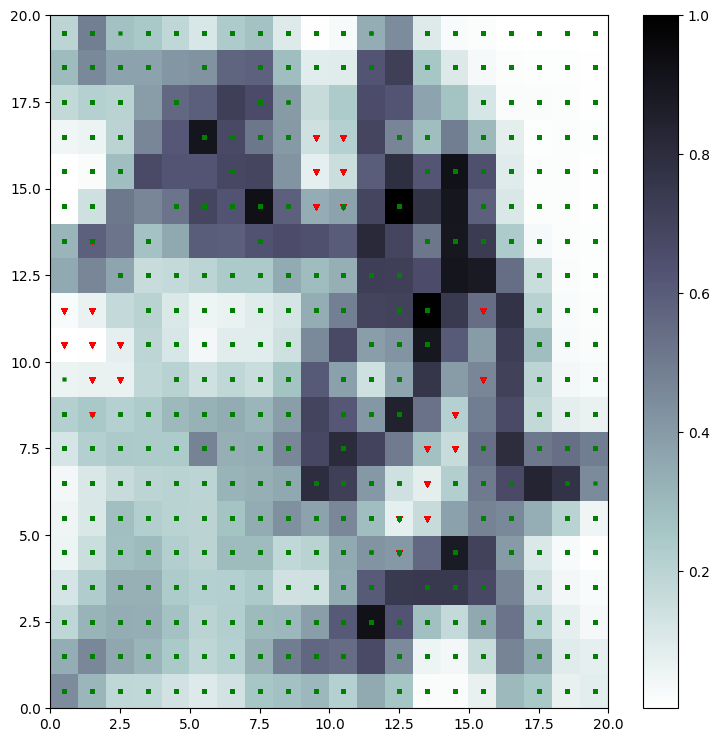

CPU times: user 13min 57s, sys: 24.2 s, total: 14min 22s
Wall time: 14min 18s


In [21]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the processed_friday_dataset
# different colors and markers for each label
markers = ['s', 'v']
colors = ['g', 'r']

for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor=colors[target[cnt]],
             markeredgecolor=colors[target[cnt]], markersize=1, markeredgewidth=2)


plt.show()

Percentage distribution (38492/820670)*100) at the densest point: 4.69031401172213%


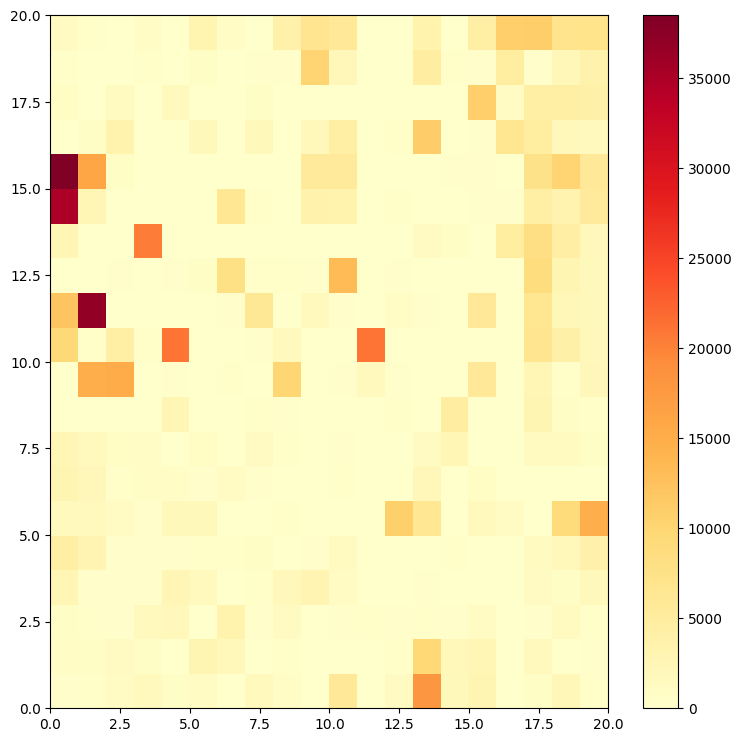

In [22]:
# Compute the activation map
frequencies = som.activation_response(data)

# Find the maximum value in the activation map
max_value = np.max(frequencies)

# Calculate the percentage distribution at the densest point
densest_point_percentage = (max_value / len(data)) * 100

# Print the percentage distribution
print(f"Percentage distribution ({int(max_value)}/{len(data)})*100) at the densest point: {densest_point_percentage}%")

# Display the activation map
plt.figure(figsize=(9, 9))
plt.pcolor(frequencies.T,cmap='YlOrRd')
plt.colorbar()
plt.show()